# Aortic Dissection Auto-segmentation for Computed Tomography (CT) 

This notebook is prepared for step-by-step description of auto-segmentation from the CT images of aortic dissection patients underwent TEVAR in Keck medical center.

In [1]:
# Import Packages

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import json
import cv2
import imageio
import os, glob
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator 


import seaborn as sns
import umetrics

In [2]:
# Define Directories

# set home directory and data directory
HOME_DIR = "./volumes/"
DATA_DIR = HOME_DIR
P0_DIR   = "P10_CTA_Chest_09_27.nii"
P0_Mask  = "P10_Segmentation_09_27.nii"
def load_case(image_nifty_file, label_nifty_file):
    # load the image and label file, get the image content and return a numpy array for each
    image = np.array(nib.load(image_nifty_file).get_fdata())
    label = np.array(nib.load(label_nifty_file).get_fdata())
    
    return image, label

image, label = load_case(DATA_DIR + "img/"+P0_DIR, DATA_DIR + "mask/" + P0_Mask)

In [3]:
# Defining the constants for the Deep Learning Model

# Define constants
SEED = 909
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_TEST = 32

IMAGE_HEIGHT = 80
IMAGE_WIDTH = 40
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

data_dir = 'slices/'
data_dir_train = os.path.join(data_dir, 'training')
# The images should be stored under: "data/slices/training/img/img"
data_dir_train_image = os.path.join(data_dir_train, 'img_aug_4')
# The images should be stored under: "data/slices/training/mask/img"
data_dir_train_mask = os.path.join(data_dir_train, 'mask_aug_4')

data_dir_test = os.path.join(data_dir, 'test')
# The images should be stored under: "data/slices/test/img/img"
data_dir_test_image = os.path.join(data_dir_test, 'img')
# The images should be stored under: "data/slices/test/mask/img"
data_dir_test_mask = os.path.join(data_dir_test, 'mask')

NUM_TRAIN = 3151 * (1 + 5)
NUM_TEST = 200

NUM_OF_EPOCHS = 50

In [4]:
# Create Image Generator for the Training/Testing

def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255, #featurewise_center=True, featurewise_std_normalization=True,
                         #featurewise_center=True,
                         #featurewise_std_normalization=True,
                         #rotation_range=45,
                         #width_shift_range=0.2,
                         #height_shift_range=0.2,
                         #zoom_range=0.3,
                        )
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return (pair for pair in zip(img_generator, msk_generator))

def create_segmentation_generator_test(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255)
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return (pair for pair in zip(img_generator, msk_generator))

#Apply the generator functions on the training and test data
train_generator = create_segmentation_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN)
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, BATCH_SIZE_TEST)

Found 18906 images belonging to 1 classes.
Found 18906 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 200 images belonging to 1 classes.


(32, 80, 40, 1) (32, 80, 40, 1)


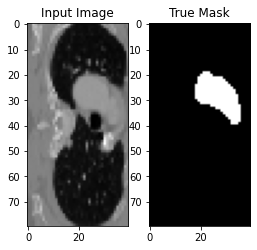

(32, 80, 40, 1) (32, 80, 40, 1)


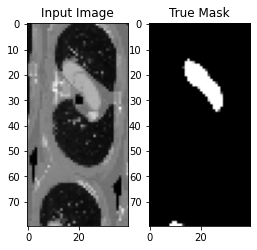

In [5]:
# Visualization

def display(display_list):
    plt.figure(figsize=(4,6))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        print(image.shape,mask.shape)
        display([image[0], mask[0]])
        
show_dataset(train_generator, 2)

In [6]:
# 2D UNET Architecture

def unet(n_levels, initial_features=32, n_blocks=2, kernel_size=3, pooling_size=2, in_channels=1, out_channels=1):
    inputs = keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, in_channels))
    x = inputs
    
    convpars = dict(kernel_size=kernel_size, activation='relu', padding='same')
    
    #downstream
    skips = {}
    for level in range(n_levels):
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
        if level < n_levels - 1:
            skips[level] = x
            x = keras.layers.MaxPool2D(pooling_size)(x)
            
    # upstream
    for level in reversed(range(n_levels-1)):
        x = keras.layers.Conv2DTranspose(initial_features * 2 ** level, strides=pooling_size, **convpars)(x)
        x = keras.layers.Concatenate()([x, skips[level]])
        for _ in range(n_blocks):
            x = keras.layers.Conv2D(initial_features * 2 ** level, **convpars)(x)
            
    # output
    activation = 'sigmoid' if out_channels == 1 else 'softmax'
    x = keras.layers.Conv2D(out_channels, kernel_size=1, activation=activation, padding='same')(x)
    
    return keras.Model(inputs=[inputs], outputs=[x], name=f'UNET-L{n_levels}-F{initial_features}')

In [7]:
# Training the Data using the 2D UNET Model

EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST

model = unet(4)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
model.summary()

Model: "UNET-L4-F32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 40, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 80, 40, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 80, 40, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 40, 20, 32)   0           ['conv2d_1[0][0]']               
                                                                                        

In [9]:
history = model.fit_generator(generator=train_generator, 
                    steps_per_epoch=EPOCH_STEP_TRAIN,  
                    epochs=NUM_OF_EPOCHS,
                    verbose = 1
                    )

Epoch 1/50


C:\Users\hengw\AppData\Local\Temp\ipykernel_27604\4016737562.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


590/590 [==============================] - 693s 1s/step - loss: 0.0873 - accuracy: 0.9706
Epoch 2/50
590/590 [==============================] - 678s 1s/step - loss: 0.0394 - accuracy: 0.9830
Epoch 3/50
590/590 [==============================] - 659s 1s/step - loss: 0.0295 - accuracy: 0.9864
Epoch 4/50
590/590 [==============================] - 650s 1s/step - loss: 0.0255 - accuracy: 0.9877
Epoch 5/50
590/590 [==============================] - 649s 1s/step - loss: 0.0227 - accuracy: 0.9886
Epoch 6/50
590/590 [==============================] - 647s 1s/step - loss: 0.0209 - accuracy: 0.9892
Epoch 7/50
590/590 [==============================] - 645s 1s/step - loss: 0.0193 - accuracy: 0.9898
Epoch 8/50
590/590 [==============================] - 647s 1s/step - loss: 0.0190 - accuracy: 0.9899
Epoch 9/50
590/590 [==============================] - 646s 1s/step - loss: 0.0172 - accuracy: 0.9906
Epoch 10/50
590/590 [==============================] - 646s 1s/step - loss: 0.0166 - accuracy: 0.9908


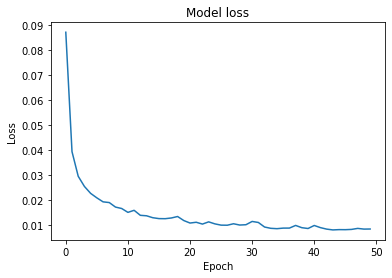

In [10]:
plt.plot(history.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [11]:
model.save(f'UNET-CardiacSegmentation_{IMAGE_HEIGHT}_{IMAGE_WIDTH}_New1.h5')

In [9]:
from tensorflow.keras.models import load_model
model = load_model('UNET-CardiacSegmentation_80_40_New1.h5')

In [ ]:
#Load Saved Model
from tensorflow.keras.models import load_model
model = load_model('UNET-CardiacSegmentation_80_40_New.h5')

In [10]:
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, 1)

Found 200 images belonging to 1 classes.
Found 200 images belonging to 1 classes.


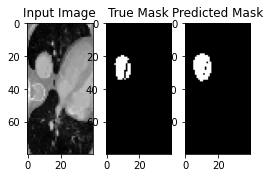

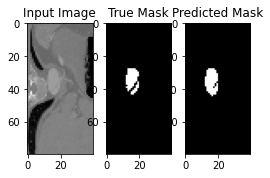

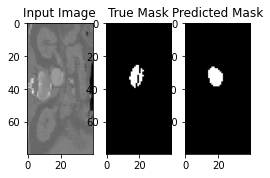

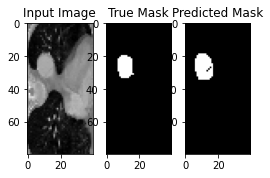

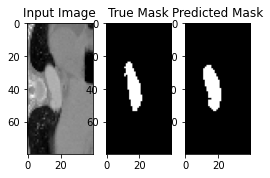

In [15]:
def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        pred_mask = model.predict(image)[0] > 0.5
        display([image[0], mask[0], pred_mask])

show_prediction(test_generator, 5)

In [12]:
# Compute the Jaccard Metric

from sklearn.metrics import jaccard_score

jaccard_results = []

jaccard_result2 = []

for i in range(NUM_TEST):
    image, mask = next(test_generator)
    pred_mask = model.predict(image)[0] > 0.5
    y_true = mask[0] > 0.5
    y_pred = pred_mask
    
    try:
        temp = umetrics.calculate(y_true[:,:,0], y_pred[:,:,0]).results.Jaccard
        jaccard_results.append(temp)
        temp2 = jaccard_score(y_true[:,:,0], y_pred[:,:,0], average='micro')
        jaccard_result2.append(temp2)
    except ZeroDivisionError:
        #TEMP = 1
        print('error')

#print('Method 1:',np.mean(jaccard_results))
#print(jaccard_results)

#for i in range(NUM_TEST):
    #image, mask = next(test_generator)
    #pred_mask = model.predict(image)[0] > 0.5
    #y_true = mask[0]
    #y_pred = pred_mask
    ##print(jaccard_score(y_true[:,:,0], y_pred[:,:,0], average='micro'))
    ##print(jaccard_score(y_true[:,:,0], y_pred[:,:,0], average='samples'))
    ##print(jaccard_score(y_true[:,:,0], y_pred[:,:,0], average='macro'))
    ##print(jaccard_score(y_true[:,:,0], y_pred[:,:,0], average=None))
    #try:
        #temp2 = jaccard_score(y_true[:,:,0], y_pred[:,:,0], average='micro')
        #jaccard_result2.append(temp2)
    #except:
        ##TEMP2 = 1
        #print('error')

print('Jaccard Method 2:',np.mean(jaccard_result2))
#print(jaccard_result2)

Jaccard Method 2: 0.7425428208922225


In [13]:
from keras import backend as K

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_coef1(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

def dice_coef2(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

dice_results = []

for i in range(NUM_TEST):
    image, mask = next(test_generator)
    pred_mask = model.predict(image)[0] > 0.5
    y_true = mask[0] > 0.5
    y_pred = pred_mask
    
    try:
        temp5 = dice_coef2(y_true, y_pred)
        dice_results.append(temp5)
    except ZeroDivisionError:
        #TEMP = 1
        print('error')
        
print('Dice:',np.mean(dice_results))
#print(dice_results)

Dice: 0.8462633


In [14]:
# Compute the Jaccard Metric

from sklearn.metrics import jaccard_score

jaccard_result3 = []

for i in range(NUM_TEST):
    image, mask = next(train_generator)
    pred_mask = model.predict(image)[0] > 0.5
    y_true = mask[0] > 0.5
    y_pred = pred_mask
    try:
        temp3 = jaccard_score(y_true[:,:,0], y_pred[:,:,0], average='micro')
        jaccard_result3.append(temp3)
    except ZeroDivisionError:
        #TEMP = 1
        print('error')
    #print(i)

print('Jaccard Method 2 [training]:',np.mean(jaccard_result3))
#print(jaccard_result3)

Jaccard Method 2 [training]: 0.879011125632812


In [18]:
result = umetrics.calculate(y_true, y_pred,  iou_threshold=0.5)
result.results

 Segmentation Metrics (n=1)
n_true_labels: 2
n_pred_labels: 2
n_true_positives: 2
n_false_positives: 0
n_false_negatives: 0
IoU: 0.893
Jaccard: 1.000
pixel_identity: 0.991
localization_error: 0.184

In [19]:
# we can modify the loss function for addressing the issues with the class imbalance

def compute_class_freqs(labels):
    """
    Compute positive and negative frequences for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

print(label[0,0,:].shape)

#Then ?

test_pos_freqs, test_neg_freqs = compute_class_freqs(label)

print(f"pos freqs: {test_pos_freqs}")

print(f"neg freqs: {test_neg_freqs}")

(800,)
pos freqs: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
neg freqs: [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [20]:
#test dict for the end
marks1 = dict(x=1,
              y=2,
              z=3)
marks2 = {"x":11,
          "y":22,
          "z":33}
def bar(**marks):
    return marks['x']
print(bar(**marks1))
print(bar(**marks2))

1
11


In [21]:
#End of the Code